In [1]:
%matplotlib widget
import numpy as np
import json, os, glob, numbers
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *

import warnings
warnings.filterwarnings('ignore')

<a id='averaged_XAS'></a>
## Load data

In [2]:
pgroup = 'p22591'
Loaddir_name = ''
    
runlist = [153]
t0_offsets = [[0] for n in range(len(runlist))]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)

In [3]:
withTT = True

###########################################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]

from sfdata import SFScanInfo
scan = SFScanInfo(firstrun)

data = []
titlestring_stack = []
data_d1 = []
titlestring_stack_d1 = []

for n in range(len(runlist)):
    a = load_reduced_data(pgroup, Loaddir, [runlist[n]], switch_diodes=True, t0_offset=t0_offsets[n])
    #b = load_reduced_data(pgroup, Loaddir, [runlist[n]], switch_diodes=False, t0_offset=t0_offsets[n])
    data.append(a[0])
    titlestring_stack.append(a[1])
    #data_d1.append(b[0])
    #titlestring_stack_d1.append(b[1])
readbacks = [np.asarray(data[n]['readbacks'], dtype=object) for n in range(len(runlist))]
#readbacks_d1 = [np.asarray(data_d1[n]['readbacks'], dtype=object) for n in range(len(runlist))]

# 1D scan

25 26 26
11531 shots out of 12833 survived


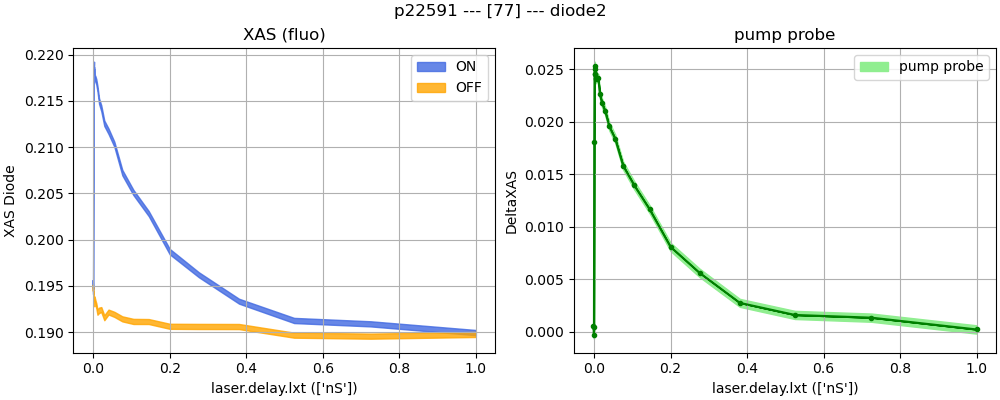

In [19]:
quantile2 = 0.95

##############################################
rbk = [np.array(readbacks[n][0], dtype=float) for n in range(len(runlist))]
indexNans = [np.ones(len(rbk[n]), dtype=bool) for n in range(len(runlist))]
#rbk_d1 =  [np.array(readbacks_d1[n][0], dtype=float) for n in range(len(runlist))]    
#indexNans_d1 = [np.ones(len(rbk_d1[n]), dtype=bool) for n in range(len(runlist))]

results = []
#results_d1 = []
for n in range(len(runlist)):
    results.append(Rebin_and_filter_energyscans_PP(data[n], quantile2, rbk[n], threshold=0, n_sigma=5, raw=True))
 #   results_d1.append(Rebin_and_filter_energyscans_PP(data_d1[n], quantile2, rbk_d1[n], threshold=0, n_sigma=5, raw=True))
    plot_filtered_data(results[n],scan,rbk[n],titlestring_stack[n])
  #  plot_filtered_data(results_d1[n],scan,rbk_d1[n],titlestring_stack_d1[n])

In [11]:
results[0].keys()


dict_keys(['pp', 'GS', 'ES', 'err_pp', 'err_GS', 'err_ES', 'err_pp2', 'err_GS2', 'err_ES2', 'filtered', 'energy'])

In [20]:
np.save('XANES_Timescan_sample1_2470p5_m2ps_1ns_77_0p95.npy',{'Delay_fs_TT':results[0]['energy'],'GS':results[0]['GS'],'ES':results[0]['ES']})

In [671]:
pp_T = []
err_pp = []
Energy = []
ES = []
GS = []

for n in range(len(runlist)):
    pp_T.append(results[n]['pp'])
    #pp_T.append(results_d1[n]['pp'])
    err_pp.append(results[n]['err_pp'])
    #err_pp.append(results_d1[n]['err_pp'])
    Energy.append(results[n]['energy'])
    #Energy.append(results_d1[n]['energy'])
    ES.append(results[n]['ES'])
    #ES.append(results_d1[n]['ES'])
    GS.append(results[n]['GS'])
    #GS.append(results_d1[n]['GS'])

In [656]:
def k_multi(Energy, GS, ref=0):
    area_ref = np.trapz(GS[ref], Energy[ref])
 #   area_ref = max(GS[ref])
    ks = []

    for i in range(len(GS)):
        area_i = np.trapz(GS[i], Energy[i])
#        area_i = max(GS[i])
        k = area_ref / area_i

        # misma lógica que tu función original
        if area_ref > area_i:
            k = 1/k   # invertir
        ks.append(k)

    return ks


In [657]:
def k(Energy,GS):
    #Factor de escala k
    area0 = np.trapz(GS[0], Energy[0]) #áreas bajo la curva
    area1 = np.trapz(GS[1], Energy[1])
    
    k = area0/area1
    
    if area0 > area1:
        return 1/k
    else:
        return k

    

In [658]:
k(Energy,GS)

np.float64(0.9841004420580232)

In [659]:
k_multi(Energy,GS)

[np.float64(1.0),
 np.float64(0.9841004420580232),
 np.float64(0.9810740578752498)]

In [660]:
def avg_scaled(Energy, GS, ref=0):
    ks = k_multi(Energy, GS, ref)
    
    scaled = []
    for i in range(len(GS)):
        scaled.append(GS[i] / ks[i])   # se escala cada espectro
    
    return np.mean(scaled, axis=0)

In [661]:
OFF_AVG = avg_scaled(Energy, GS, ref=0)
ON_AVG = avg_scaled(Energy, ES, ref=0)

In [662]:
#OFF_AVG = (GS[0] + (GS[1])/k(Energy,GS)) /2
#ON_AVG = (ES[0] + (ES[1])/k(Energy,GS)) /2

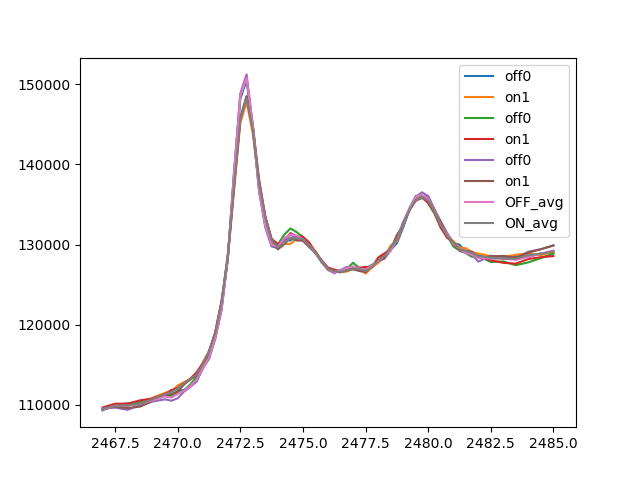

In [663]:
plt.figure()
for n in range(len(runlist)): 
    plt.plot(Energy[n],GS[n]/k_multi(Energy,GS)[n],label='off0')
    plt.plot(Energy[n],ES[n]/k_multi(Energy,GS)[n],label='on1')
plt.plot(Energy[0],OFF_AVG,label='OFF_avg')
plt.plot(Energy[0],ON_AVG,label='ON_avg')
plt.legend()
plt.show()

In [664]:
pp_AVG = ON_AVG - OFF_AVG
err_pp_avg = np.mean(err_pp, axis=0)

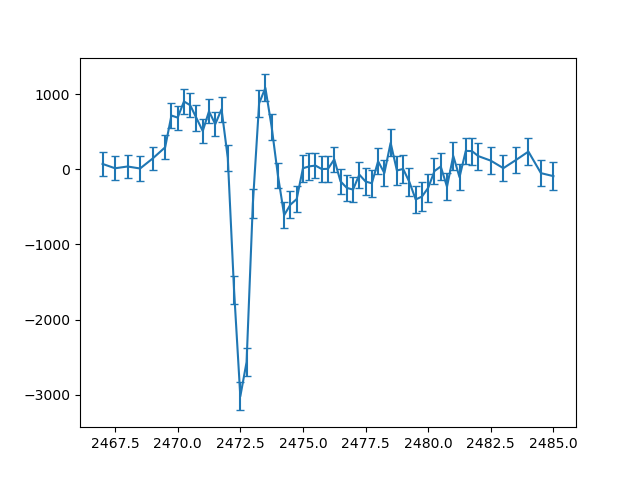

In [665]:
plt.figure()
plt.errorbar(Energy[0],pp_AVG,yerr=err_pp_avg,capsize=3)
#plt.errorbar(Energy[0],ES[0] - GS[0],yerr = err_pp[0],capsize=3)
plt.show()

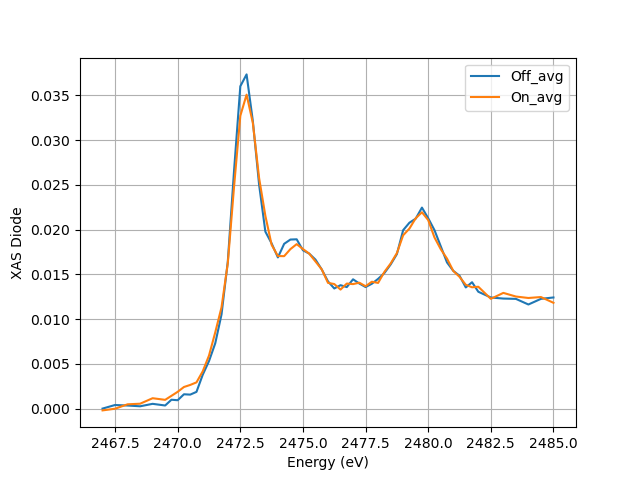

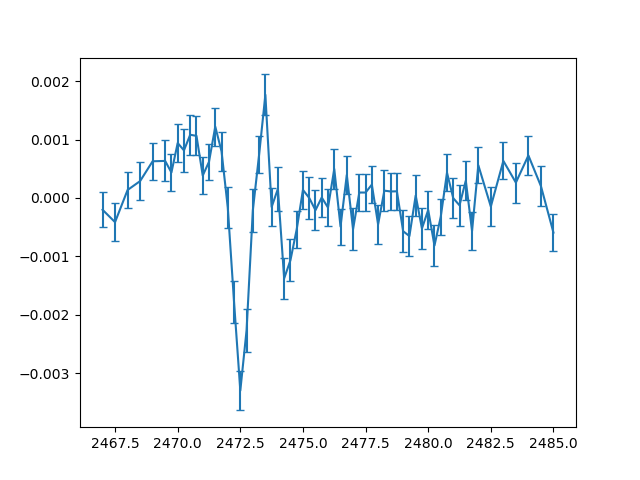

In [673]:
pp_AVG = ES[0] - GS[0]
err_pp_avg = err_pp[0]
ymin = min(GS[0])
y_off = (GS[0] - ymin)
y_on = (ES[0] - ymin)
plt.figure()
plt.plot(Energy[0],y_off, label ='Off_avg')
plt.plot(Energy[0],y_on, label = 'On_avg')
plt.grid()
plt.xlabel('Energy (eV)')
plt.ylabel('XAS Diode')
plt.legend()
plt.show()
plt.figure()
plt.errorbar(Energy[0],pp_AVG,yerr=err_pp_avg,capsize=3)
#plt.errorbar(Energy[0],ES[0] - GS[0],yerr = err_pp[0],capsize=3)
plt.show()

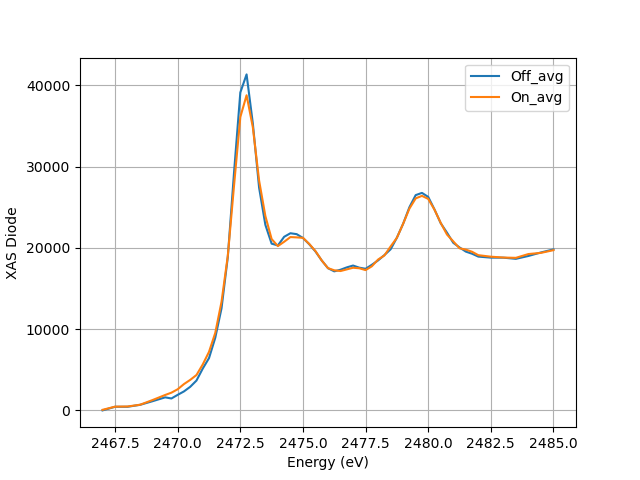

In [666]:
ymin = min(OFF_AVG)
ymax = max(OFF_AVG[-10:] - ymin)
y_off = (OFF_AVG - ymin)
y_on = (ON_AVG - ymin)
plt.figure()
plt.plot(Energy[0],(OFF_AVG - ymin), label ='Off_avg')
plt.plot(Energy[0],(ON_AVG - ymin), label = 'On_avg')
plt.grid()
plt.xlabel('Energy (eV)')
plt.ylabel('XAS Diode')
plt.legend()
plt.show()

In [667]:
np.save('XANES_sample5_1ps_182_186_187_0p95.npy',{'y_off':y_off,'y_on':y_on,'E':Energy[0],'pp_avg':pp_AVG,'err_pp_avg':err_pp_avg})

In [674]:
np.save('XANES_sample5_500fs_167_0p95.npy',{'y_off':y_off,'y_on':y_on,'E':Energy[0],'pp_avg':ES[0] - GS[0],'err_pp_avg':err_pp[0]})


# 2D scan

In [4]:
quantile = 0.75

withTT =True

binsize = 30
min_delay = -250
max_delay = 1000

(variable_bins_delay, numbins) = (False, 100)


##############################################
rbk = np.array(readbacks[0], dtype=float)

#results1 = Rebin_and_filter_2Dscans(data1, binsize, min_delay, max_delay, quantile, rbk, withTT, threshold=0.01, n_sigma=5, varbin_t=variable_bins_delay, numbins=numbins)
results2 = Rebin_and_filter_2Dscans(data2, binsize, min_delay, max_delay, quantile, rbk, withTT, threshold=0.01, n_sigma=5, varbin_t=variable_bins_delay, numbins=numbins)

#pp_TT = (results1['pp']+results2['pp'])/2
pp_TT = results2['pp']

Delay_fs_TT = results2['Delay']
#pp_TT       = results['pp']

NameError: name 'data2' is not defined

TypeError: Dimensions of C (48, 41) should be one smaller than X(41) and Y(62) while using shading='flat' see help(pcolormesh)

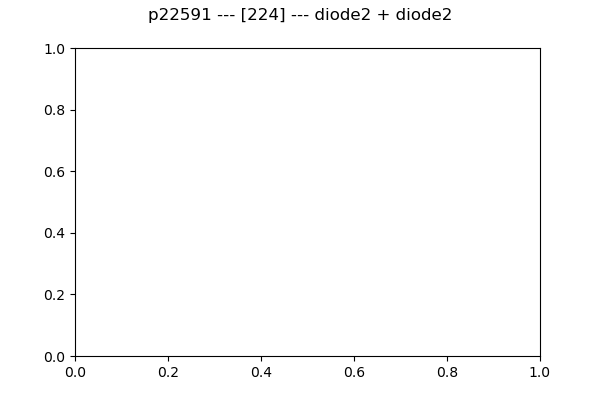

In [216]:
import matplotlib.colors as colors
baseline = np.average(pp_TT[:,0:2], axis=1)
#baseline = np.average(GS[:,0:2], axis=1)
baseline = 0 #baseline[:, np.newaxis]

# Delay_fs_TT_2 = Delay_fs_TT[~np.isnan(Delay_fs_TT)]
# pp_TT = pp_TT[:,~np.isnan(Delay_fs_TT)]

plt.figure(figsize=(6, 4))
#plt.rcParams.update({'font.size': 15})
#plt.suptitle(titlestring_stack1)
plt.suptitle(titlestring_stack1 +' + diode2')
#plt.title(runlist)

vmin = -0.03
vmax = 0.01
n = 30
levels = np.linspace(vmin, vmax, n+1)

plt.pcolormesh(Delay_fs_TT, rbk, pp_TT-baseline, cmap='turbo',vmin=vmin, vmax=vmax)
#plt.contourf(pp_TT-baseline, cmap='seismic', levels=levels, extent=[Delay_fs_TT[0], Delay_fs_TT[-1], rbk[0], rbk[-1]], extend='both')
#plt.pcolormesh(Delay_fs_TT+0, rbk, ES-baseline, cmap='jet')#, vmin=-0.004, vmax = 0.011)

#plt.pcolormesh(pp_TT-baseline, cmap='bwr', vmin=-0.1, vmax = 0.1)
#plt.ylabel('{} ({})'.format(_averagedscan.parameters['name'][0],scan.parameters['units'][0]))
plt.ylabel('Photon energy (eV)')

cbar = plt.colorbar(fraction=0.15)
cbar.set_label('Diff absorbance (OD)', rotation=270, labelpad=25)
#plt.colorbar()

plt.xlabel('Delay (fs)')
plt.axvline(x = 0, color = 'k', linestyle = '--')
#plt.grid()
plt.tight_layout()
plt.show()

In [76]:
np.save('data_2D_56_alex.npy',{'data_c':pp_TT - baseline,'TD':Delay_fs_TT,'WL':rbk})

TypeError: Dimensions of C (48, 41) should be one smaller than X(41) and Y(62) while using shading='flat' see help(pcolormesh)

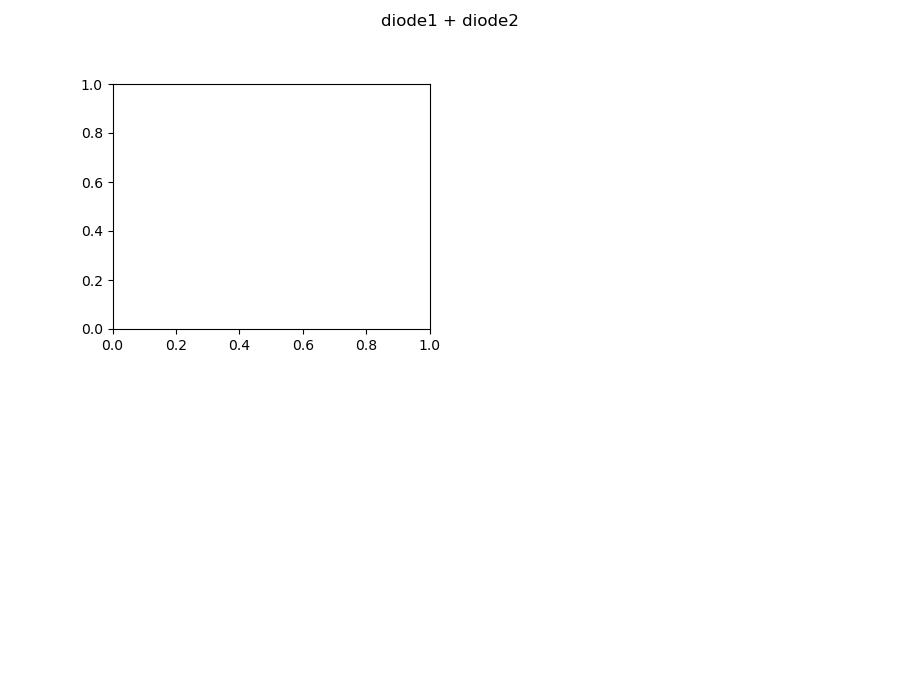

In [217]:
delay_integration = 100
energy_bin = 1

energylist = [2468,2469,2471.5,2474.5]
delayslist = [0,25,50,100,200,500,800]

import matplotlib.colors as colors
norms = colors.LogNorm(vmin=0, vmax=1, clip=False)

f = plt.figure(figsize=(9,7))
#plt.suptitle(titlestring_stack1)
plt.suptitle('diode1 + diode2')
gs = gridspec.GridSpec(2,2, height_ratios=[2,2], width_ratios=[2,2])
ax1 = plt.subplot(gs[0,0])
#ax1.pcolormesh(Delay_fs_TT, rbk, pp_TT-baseline, cmap='seismic',vmin=vmin, vmax=vmax)
ax1.pcolormesh(Delay_fs_TT, rbk, pp_TT-baseline, cmap='turbo',vmin=vmin, vmax=vmax)
#ax1.pcolormesh(Delay_fs_TT, rbk, np.log(pp_TT-baseline), cmap='jet')#, norm=norms)#,vmin=vmin, vmax=vmax)
ax1.hlines(energylist, ls='--', color='black', xmin=0, xmax=100)
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[0,1])

for energy in energylist:
    index_energy = np.arange(len(rbk))[(np.array(rbk) > energy)][0]
    print (index_energy)
    ax1.hlines(energylist, ls='--', color='black', xmin=min(Delay_fs_TT), xmax=max(Delay_fs_TT))
    #cut_e = np.mean(np.array(pp_TT-baseline)[np.arange(index_energy-energy_bin,index_energy+energy_bin+1),:], axis=0)
    cut_e = np.array(pp_TT-baseline)[index_energy,:]
    ax2.plot(Delay_fs_TT, cut_e, label=energy)
    #ax2.plot(Delay_fs_TT, np.array(pp_TT-baseline)[index_energy], label=energy)
    ax2.legend(loc='best')

for time in delayslist:
    index_delay = np.arange(len(Delay_fs_TT))[(np.array(Delay_fs_TT) > time)][0]
    ax1.vlines(delayslist, ls='--', color='gray', ymin=min(rbk), ymax=max(rbk))
    #cut_d = np.mean(np.array(pp_TT-baseline)[:,index_delay-delay_integration//binsize:index_delay+delay_integration//binsize], axis=1)
    cut_d = np.array(pp_TT-baseline)[:,index_delay]
    ax3.plot(rbk, cut_d, label=time)
    #ax3.plot(rbk,np.array(pp_TT-baseline)[:,index_delay],label =time)
    #ax3.vlines(7121.5, ls='--',ymin=-0.15,ymax=0.4, color='gray')
    #ax3.vlines(7125.5, ls='--',ymin=-0.15,ymax=0.4, color='gray')

    ax3.legend(loc='best')
#ax1.set_xscale('log')
ax2.grid()
ax3.grid()
plt.tight_layout()

## Time-zero alignment - signal at 7124 eV

In [16]:
pgroup = 'p22250'
Loaddir_name = ''

#runlist = np.arange(41, 45)
runlist = [149]

t0_offsets = [0]*len(runlist)   # run this later to check it is aligned
##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)
#Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)

34 35 32
Time delay axis rebinned with TT data
19541 shots out of 258832 survived (7.55%)


IndexError: index 0 is out of bounds for axis 0 with size 0

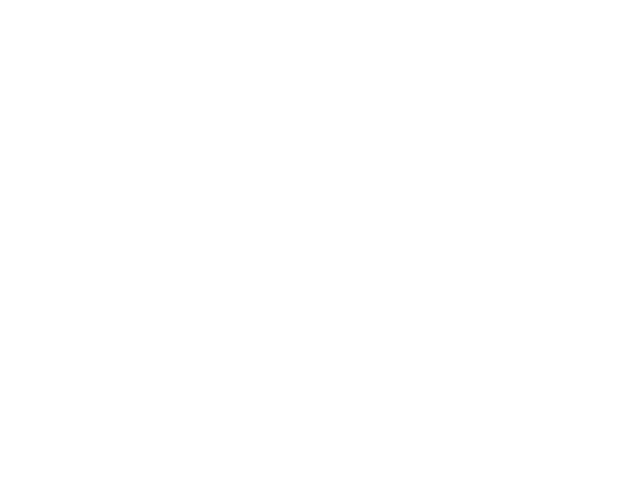

In [49]:
switch_diodes = False   #False for Diode 1, True for diode 2

quantile = 0.9

withTT = True
binsize = 10
min_delay = -75
max_delay = 250

(variable_bins_delay, numbins) = (False, 100)

energycut = 7124
#baseline = np.average(pp_TT[:,0:2], axis=1)
baseline = 0 #baseline[:, np.newaxis]

plt.figure()
offset = []           # uncomment for first run to check the time-zero values of each run
for index, run in enumerate(runlist):
    #print (run)
    t0_off = [t0_offsets[index]]
    data = {}
    globals().update(data)
    data1, titlestring_stack1 = load_reduced_data(pgroup, Loaddir, [run], switch_diodes=switch_diodes, t0_offset=t0_off)
    
    readbacks = np.asarray(data1['readbacks'], dtype=object)
    rbk = np.array(readbacks[0], dtype=float)
    globals().update(data)

    results = Rebin_and_filter_2Dscans(data1, binsize, min_delay, max_delay, quantile, rbk, withTT, threshold=0.01, n_sigma=3, varbin_t=variable_bins_delay, numbins=numbins)

    pp_TT = results['pp']
    Delay_fs_TT = results['Delay']

    index_energy = np.arange(len(rbk))[(np.array(rbk) > energycut)][0]
    cut = np.mean(np.array(pp_TT-baseline)[index_energy-1:index_energy+1, :], axis=0)
    cut_derivative = gaussian_filter1d(cut, 1, order = 1)
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(cut_derivative))
    Delay_fs_TT = Delay_fs_TT[index]
    cut_derivative=  cut_derivative[index]
    
    parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, cut_derivative, p0 = [50, 0.1, 50, 0])
    #print (index_energy)
   # plt.plot(Delay_fs_TT, alignment, label=run) # comment for first run
    plt.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green')
    offset.append(-parameters_M2[0])           # comment after checking time-zero values for each run and run again this cell
plt.legend(loc='best')
plt.grid()
plt.tight_layout()

In [28]:
offset

[np.float64(-14.896356793580694)]

## Overlay data

In [203]:
pgroup = 'p22591'

runlist2load = [98,109,107,105,103]

#runlist2load = [78, 34]
#runlist2load = [21, 24, 28, 29, 30, 33, 34, 52, 53, 55, 58, 59, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 74, 75, 76, 77]

Loaddir_folder = '_singlerun' #_single #_multiruns
whichdiode = 'diode2'  #both_diodes
# whichdiode = 'diode1'  #both_diodes

whichaverage = [0,0,0,0]
##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_folder)

titlestring_stack = pgroup + ' --- ' +str(runlist2load)
print ('Will load {} runs: {} from {}'.format(len(runlist2load), runlist2load, Loaddir))
check = []
for i, (run, avg) in enumerate(zip(runlist2load, whichaverage)):
    try:
        check.append(glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run, whichdiode))[avg])
    except:
        print("Some runs are missing")
check

Will load 5 runs: [98, 109, 107, 105, 103] from /sf/alvra/data/p22591/work/Reduced_data/_singlerun/


['/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run98/run_array_diode2.npy',
 '/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run109/run_array_diode2.npy',
 '/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run107/run_array_diode2.npy',
 '/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run105/run_array_diode2.npy']

/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run98/run_array_diode2.npy
/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run109/run_array_diode2.npy
/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run107/run_array_diode2.npy
/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run105/run_array_diode2.npy


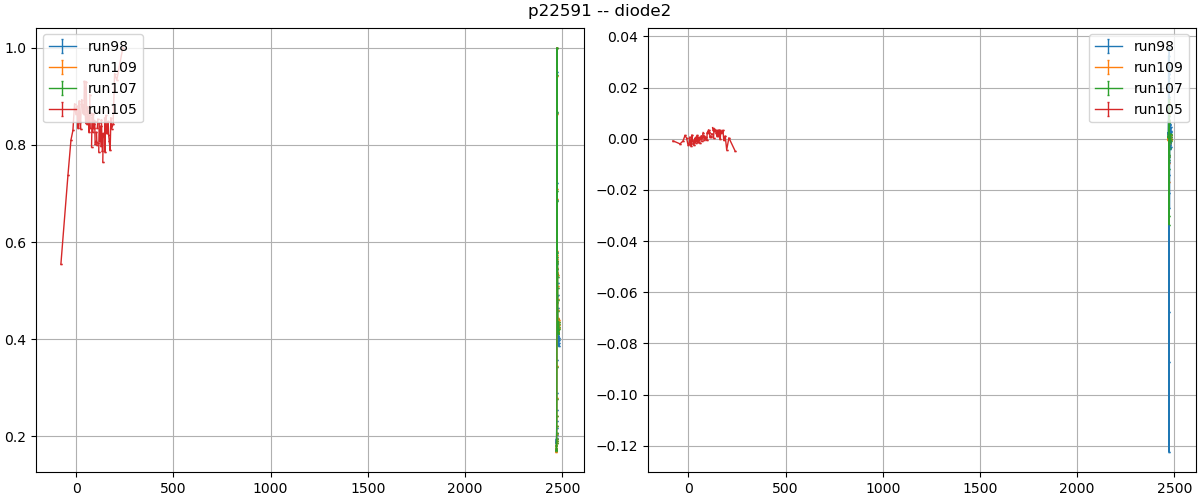

In [204]:
fig, ((ax1, ax3)) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
if whichdiode=='diode2':
    switchdiode=False
else:
    switchdiode=True
peak = []
#lab=['470nm 1ps','470nm_2 1ps', '595nm 100fs','595nm 350fs', '330ps','1ns','350fs']
# scale = [1.75,2.6,3.5,1,1]*len(runlist2load)
scale = [1/7500,100]*len(runlist2load)

for index, (run, avg) in enumerate(zip(runlist2load, whichaverage)):
#for index, run in enumerate(runlist2load):
    filepath = glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run, whichdiode))[avg]
    print(filepath)
    run_array = np.load(filepath, allow_pickle=True).item()
    for key in run_array.keys():
        runname  = run_array[key]["name"].split('-')[0]
        GS       = run_array[key]["GS"]
        err_GS   = run_array[key]["err_GS"]
        
        ES       = run_array[key]["ES"]
        err_ES   = run_array[key]["err_ES"]
        pp_rebin = run_array[key]["pp"]
        err_pp   = run_array[key]["err_pp"]
        rbk      = run_array[key]["readbacks"]
    # print(index)
    peak.append(max(GS)-np.mean(GS[:5]))
    ax1.errorbar(rbk, GS/max(GS), 0, lw=1,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label=runname)#+'-'+str(lab[index]))
    #ax3.errorbar(rbk, pp_rebin*scale[index], 0, lw=1,markersize=0,capsize=1,capthick=1,
                  # elinewidth=1,label=runname)#+'-'+str(lab[index]))
    ax3.errorbar(rbk, pp_rebin, 0, lw=1,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label=runname)#+'-'+str(lab[index]))
    
plt.suptitle('{} -- {}'.format(pgroup, whichdiode))
ax1.legend(loc = 'upper left')
ax1.grid()
ax3.legend(loc = 'upper right')
ax3.grid()

In [197]:
ttime = []
ff = []
for run in runlist2load:
    f = glob.glob('/sf/alvra/data/p22588/raw/*{:04d}*/meta/scan.json'.format(run))[0]
    print (f)
    ff.append(f)
    #ttime.append(timestamp_hms(f))
    ttime.append(creation_date(f))

/sf/alvra/data/p22588/raw/run0021-PtLQ_XANES_1ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0024-PtLQ_XANES_1ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0028-PtLQ_XANES_100fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0029-PtLQ_XANES_100fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0030-PtLQ_XANES_500fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0033-PtLQ_XANES_1ps_1uJ_001/meta/scan.json
/sf/alvra/data/p22588/raw/run0034-PtLQ_XANES_1ps_1uJ_002/meta/scan.json
/sf/alvra/data/p22588/raw/run0052-PtLQ_XANES_200fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0053-PtLQ_XANES_350fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0055-PtLQ_XANES_5ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0058-PtLQ_XANES_10ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0059-PtLQ_XANES_10ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0060-PtLQ_XANES_10ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0061-PtLQ_XANES_20ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/

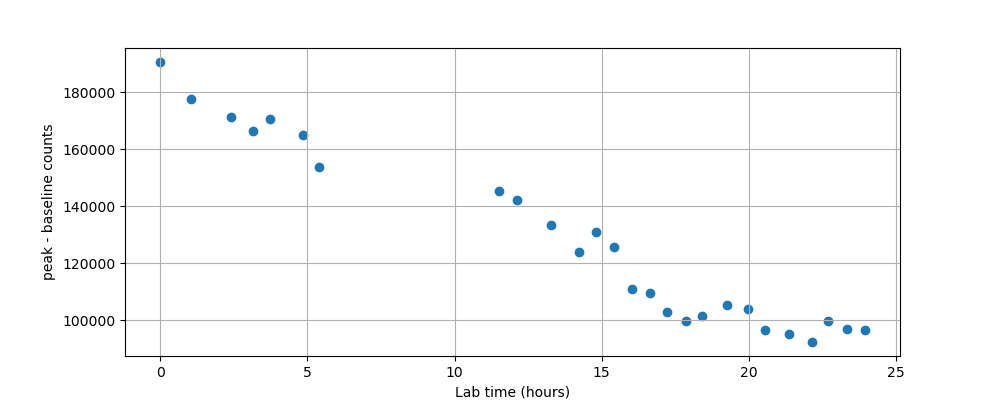

In [198]:
plt.figure(figsize=(10,4))
plt.scatter((np.array(ttime)-np.array(ttime)[0])/3600, peak)
#plt.scatter(ttime, peak)
#plt.gcf().autofmt_xdate()


plt.ylabel('peak - baseline counts')
plt.xlabel('Lab time (hours)')
plt.grid()
plt.show()

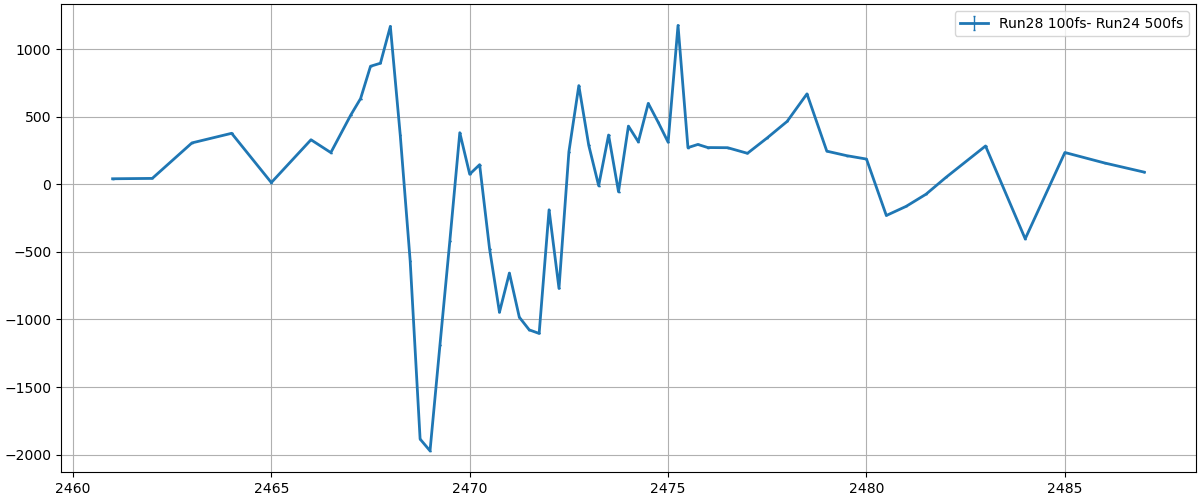

In [15]:
fig, ((ax1)) = plt.subplots(1, 1, figsize=(12, 5), constrained_layout=True)
if whichdiode=='diode1':
    switchdiode=False
else:
    switchdiode=True

run1 = 28
run2 = 24

label1 = '100fs'
label2 = '500fs'

filepath1 = glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run1, whichdiode))[0]
filepath2 = glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run2, whichdiode))[0]
run_array1 = np.load(filepath1, allow_pickle=True).item()
run_array2 = np.load(filepath2, allow_pickle=True).item()

for key in run_array1.keys():
        
        runname  = run_array1[key]["name"].split('-')[0]
        GS       = run_array1[key]["GS"]
        err_GS   = run_array1[key]["err_GS"]
        ES       = run_array1[key]["ES"]
        err_ES   = run_array1[key]["err_ES"]
        pp_rebin1 = run_array1[key]["pp"]
        err_pp   = run_array1[key]["err_pp"]
        rbk1     = run_array1[key]["readbacks"]

for key in run_array2.keys():
        runname  = run_array2[key]["name"].split('-')[0]
        GS       = run_array2[key]["GS"]
        err_GS   = run_array2[key]["err_GS"]
        ES       = run_array2[key]["ES"]
        err_ES   = run_array2[key]["err_ES"]
        pp_rebin2 = run_array2[key]["pp"]
        err_pp   = run_array2[key]["err_pp"]
        rbk2     = run_array2[key]["readbacks"]

# plt.show()

# plt.show()
# plt.suptitle('{} -- {}'.format(pgroup, whichdiode))
# ax1.legend(loc = 'upper left')
# ax1.grid()
# ax3.legend(loc = 'upper left')
# ax3.grid()



ax1.errorbar(rbk1, pp_rebin1-pp_rebin2, 0, lw=2,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label = 'Run'+str(run1)+' '+label1 +'- Run'+str(run2)+' '+label2)
ax1.legend()
plt.grid()
plt.show()